In [1]:
#주파수 도메인에서 전자기장을 나타내는 데이터를 저장하고 처리하는데 사용됩니다. 공간 도메인에서 시간 도메인으로 전자기장을 변환하는 푸리에 변환을 수행
#전자기파 시뮬레이션 결과를 주파수 도메인으로 변환하여 저장합니다. 전자기장의 크기와 위상 정보

Defining mpa.FourierFields is similar to define mpa.EigenmodeCoefficient, but we pass a component of interest intead of mode number. We can define several components, and let the objective be a function of them simultaneously.

The first axis of the value returned by Fourier Fields corresponds to the index of frequency; the rest has the dimensions of the monitor. In this case, it is 1D, so we simply provide the index of point at which we would like to optimize the fields.

The objective function can involve several fields component, at several frequencies, and involve several points. Since we specify the points by indices, it is probably more common to have an objective as an average/sum of values at all points, where we don't need specific indices and just use `:` instead.

Also note that the optimization problem includes a wider frequency spectrum, but the particular objective defined below depends on one frequency only. Alternatively, we can define a single frequency from the start.

In [2]:
# 시뮬레이션 라이브러리 불러오기
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import pickle
import sys

# 물질 설정 및 Refractive Index 설정
mp.verbosity(0)
Si = mp.Medium(index=3.4)
SiO2 = mp.Medium(index=1.44)

In [3]:
waveguide_width = 0.5
design_region_width = 2
design_region_height = 2

waveguide_length = 0.5

pml_size = 1.0

resolution = 20

frequencies = 1 / np.linspace(1.5, 1.6, 3)

In [4]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = (
    0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
print(filter_radius)
design_region_resolution = int(1 * resolution)


Sx = 2 * pml_size + 2 * waveguide_length + design_region_width + 2
Sy = 2 * pml_size + design_region_height + 2
cell_size = mp.Vector3(Sx, Sy)

pml_layers = [mp.PML(pml_size)]

fcen = 1 / 1.55
width = 0.2
fwidth = width * fcen
source_center = [-Sx / 2 + pml_size + waveguide_length / 3, 0, 0]
source_size = mp.Vector3(0, Sy, 0)
kpoint = mp.Vector3(1, 0, 0)
src = mp.GaussianSource(frequency=fcen, fwidth=fwidth)
source = [
    mp.EigenModeSource(
        src,
        eig_band=1,
        direction=mp.NO_DIRECTION,
        eig_kpoint=kpoint,
        size=source_size,
        center=source_center,
    )
]

0.20124611797498096


In [5]:
Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si)
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

left_wg_mask = (X_g == -design_region_width / 2) & (np.abs(Y_g) <= waveguide_width / 2)
top_wg_mask = (Y_g == design_region_width / 2) & (np.abs(X_g) <= waveguide_width / 2)
Si_mask = left_wg_mask | top_wg_mask

border_mask = (
    (X_g == -design_region_width / 2)
    | (X_g == design_region_width / 2)
    | (Y_g == -design_region_height / 2)
    | (Y_g == design_region_height / 2)
)
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False

# filter.py conic_filter 함수와 simple_2d_filter 함수를 사용
def mapping(x, eta, beta):
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    # 출력값 -1 ~ 1으로 제한
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return projected_field.flatten()

geometry = [
    mp.Block(
        center=mp.Vector3(x=-Sx / 4), material=Si, size=mp.Vector3(Sx / 2, 0.5, 0)
    ),  # horizontal waveguide
    mp.Block(
        center=mp.Vector3(y=Sy / 4), material=Si, size=mp.Vector3(0.5, Sy / 2, 0)
    ),  # vertical waveguide
    mp.Block(
        center=design_region.center, size=design_region.size, material=design_variables
    ),  # design region
]

In [6]:
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=pml_layers,
    geometry=geometry,
    sources=source,
    default_material=SiO2,
    resolution=resolution,
)

In [7]:
mode = 1

Ez_top = mpa.EigenmodeCoefficient(
    sim,
    mp.Volume(
        center=mp.Vector3(0, Sy / 2 - pml_size - 0.1, 0),
        size=mp.Vector3(x=waveguide_width),
    ),
    mode,
)
ob_list = [Ez_top]

In [8]:
#def J(fields):
#    return npa.mean(npa.abs(fields) ** 2)
def J_0(fields):
    return npa.mean(npa.abs(fields[0]) ** 2)
def J_1(fields):
    return npa.mean(npa.abs(fields[1]) ** 2) 
def J_2(fields):
    return npa.mean(npa.abs(fields[2]) ** 2) 

In [9]:
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J_0, J_1, J_2],
    #objective_functions=J
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=frequencies,
    maximum_run_time=2000,
)

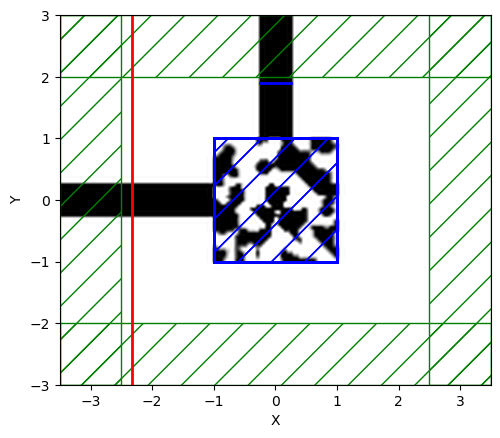

In [10]:
rho_vector = np.random.rand(Nx * Ny)
opt.update_design([mapping(rho_vector, eta_i, 1e3)])
opt.plot2D(True)
plt.show()

In [11]:
evaluation_history = []
cur_iter = [0]

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, beta)])  # compute objective and gradient
    
    # Adjoint gradient
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=1)
        )  # backprop

    evaluation_history.append(np.real(f0))

# plot 기능
    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

In [12]:
algorithm = nlopt.LD_MMA # 어떤 알고리즘으로 최적화를 할 것인가?
# MMA : 점근선 이동

n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5
x[Si_mask.flatten()] = 1  # set the edges of waveguides to silicon
x[SiO2_mask.flatten()] = 0  # set the other edges to SiO2

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
lb[Si_mask.flatten()] = 1
ub = np.ones((Nx * Ny,))
ub[SiO2_mask.flatten()] = 0

# Optimization parameter
cur_beta = 4
beta_scale = 2 
num_betas = 5
update_factor = 15  # number of iterations between beta updates
ftol = 1e-5 

# for iters in range(num_betas):
#     solver = nlopt.opt(algorithm, n)
#     solver.set_lower_bounds(lb) # lower bounds
#     solver.set_upper_bounds(ub) # upper bounds
#     solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
#     # solver.set_max_objective(lambda a, g: f1(a, g, cur_beta), lambda a, g: f2(a, g, cur_beta), lambda a, g: f3(a, g, cur_beta)) # Set the objective function to be maximized
#     solver.set_maxeval(update_factor) # Set the maximum number of function evaluations
#     solver.set_ftol_rel(ftol) # Set the relative tolerance for convergence
#     x[:] = solver.optimize(x)
#     cur_beta = cur_beta * beta_scale # Update the beta value for the next iteration

In [13]:
f0, dJ_du = opt([mapping(x, eta_i, cur_beta / beta_scale)], need_gradient=True)

Starting forward run...
Starting adjoint run...


/home/user/anaconda3/envs/mp/lib/python3.11/site-packages/meep/adjoint/filter_source.py:175: RuntimeWarning: divide by zero encountered in divide
  l2_err = np.sum(np.abs(H - H_hat.T) ** 2 / np.abs(H) ** 2)


Calculating gradient...


In [14]:
dJ_du_0 = np.array_split(np.squeeze(dJ_du), 3)[0]
dJ_du_1 = np.array_split(np.squeeze(dJ_du), 3)[1]
dJ_du_2 = np.array_split(np.squeeze(dJ_du), 3)[2]

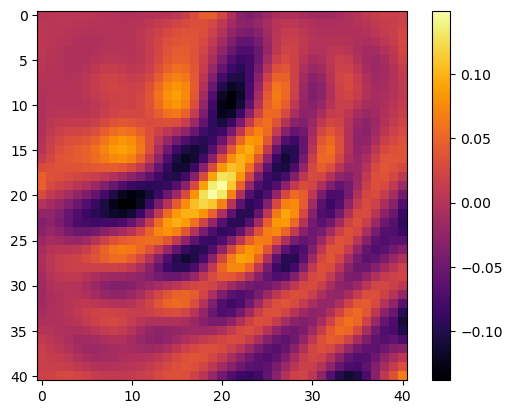

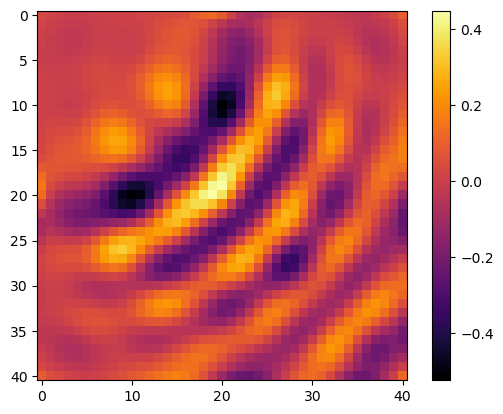

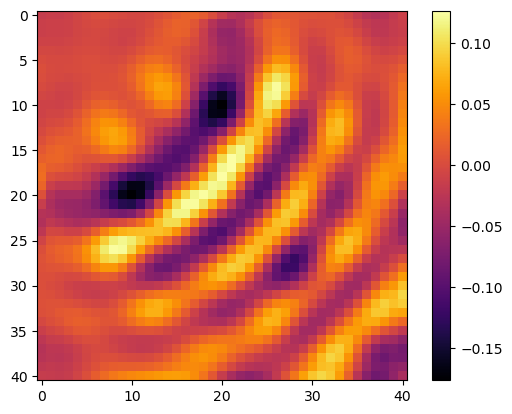

In [15]:
plt.figure()
plt.imshow(np.rot90(dJ_du_0[0,:,0].reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_0[0,:,0]), vmax=np.max(dJ_du_0[0,:,0]))
plt.colorbar()
plt.figure()
plt.imshow(np.rot90(dJ_du_1[0,:,1].reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_1[0,:,1]), vmax=np.max(dJ_du_1[0,:,1]))
plt.colorbar()
plt.figure()
plt.imshow(np.rot90(dJ_du_2[0,:,2].reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_2[0,:,2]), vmax=np.max(dJ_du_2[0,:,2]))
plt.colorbar()
#plt.savefig("adjoint_gradient_map.png")

In [16]:
db = 1e-3
choose = 1681
g_discrete, idx = opt.calculate_fd_gradient(num_gradients=choose, db=db)
g_discrete_0 = np.squeeze(g_discrete)[:,0]
g_discrete_1 = np.squeeze(g_discrete)[:,1]
g_discrete_2 = np.squeeze(g_discrete)[:,2]

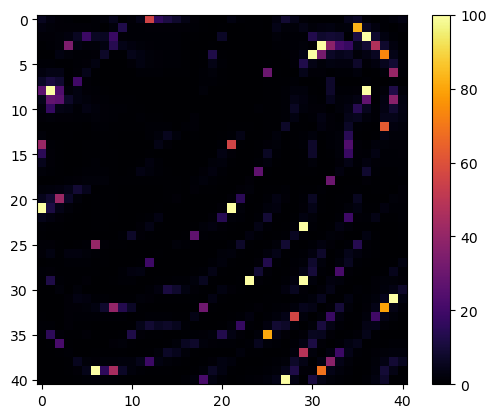

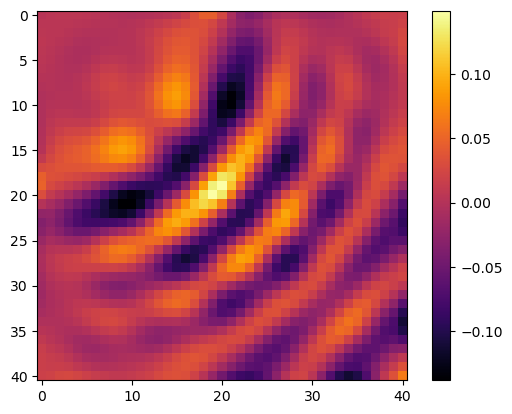

In [17]:
err_0= (np.abs(np.squeeze(g_discrete_0) - np.squeeze(dJ_du_0[0,idx,0]))
    / np.abs(np.squeeze(g_discrete_0))
    * 100)
plt.imshow(np.rot90(err_0.reshape(Nx, Ny)),cmap="inferno", vmin=0, vmax=100)
plt.colorbar()
#plt.savefig("err_res20.png")

plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete_0).reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_0[0,:,0]), vmax=np.max(dJ_du_0[0,:,0]))
#plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=-35, vmax=25)
plt.colorbar()
#plt.savefig("FD_gradient_map.png")

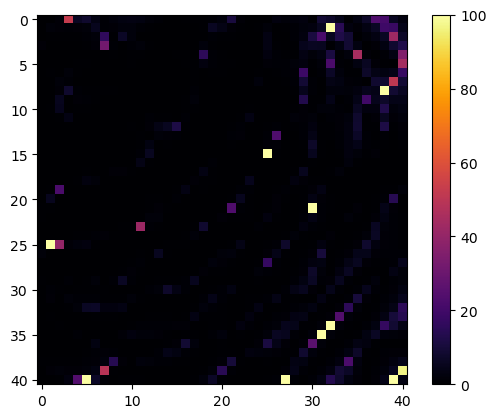

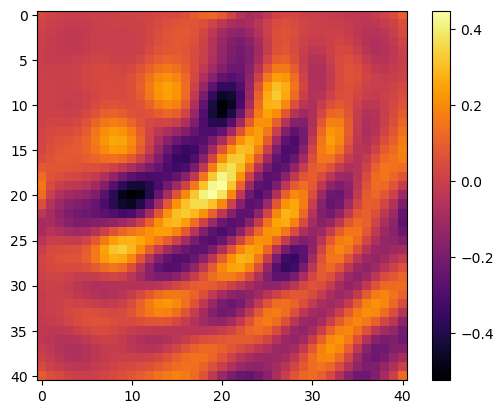

In [18]:
err_1= (np.abs(np.squeeze(g_discrete_1) - np.squeeze(dJ_du_1[0,idx,1]))
    / np.abs(np.squeeze(g_discrete_1))
    * 100)
plt.imshow(np.rot90(err_1.reshape(Nx, Ny)),cmap="inferno", vmin=0, vmax=100)
plt.colorbar()
#plt.savefig("err_res20.png")

plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete_1).reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_1[0,:,1]), vmax=np.max(dJ_du_1[0,:,1]))
#plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=-35, vmax=25)
plt.colorbar()
#plt.savefig("FD_gradient_map.png")

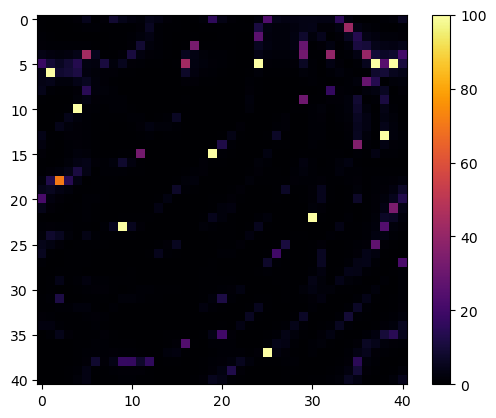

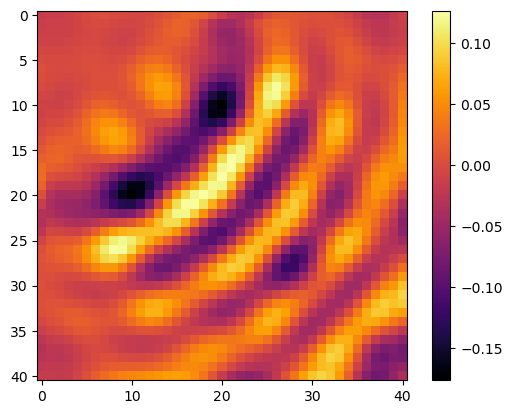

In [19]:
err_2= (np.abs(np.squeeze(g_discrete_2) - np.squeeze(dJ_du_2[0,idx,2]))
    / np.abs(np.squeeze(g_discrete_2))
    * 100)
plt.imshow(np.rot90(err_2.reshape(Nx, Ny)),cmap="inferno", vmin=0, vmax=100)
plt.colorbar()
#plt.savefig("err_res20.png")

plt.figure()
plt.imshow(np.rot90(np.squeeze(g_discrete_2).reshape(Nx, Ny)),cmap="inferno", vmin=np.min(dJ_du_2[0,:,2]), vmax=np.max(dJ_du_2[0,:,2]))
#plt.imshow(np.rot90(np.squeeze(g_discrete).reshape(Nx, Ny)),cmap="inferno", vmin=-35, vmax=25)
plt.colorbar()
#plt.savefig("FD_gradient_map.png")

In [20]:
(m0, b0) = np.polyfit(g_discrete_0, dJ_du_0[0,idx,0], 1)
(m1, b1) = np.polyfit(g_discrete_1, dJ_du_1[0,idx,1], 1)
(m2, b2) = np.polyfit(g_discrete_2, dJ_du_2[0,idx,2], 1)

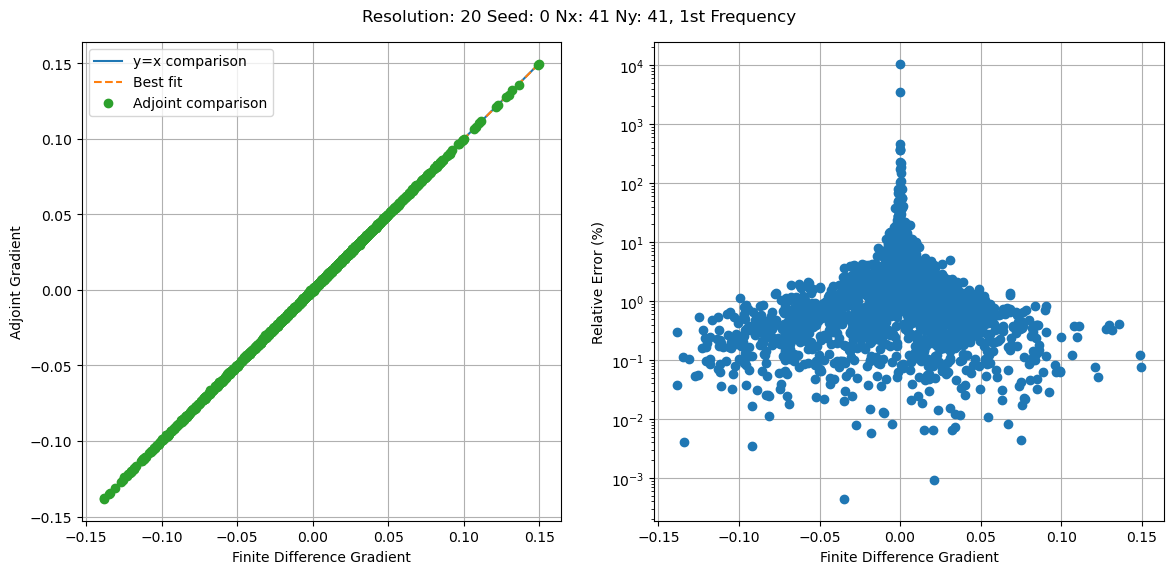

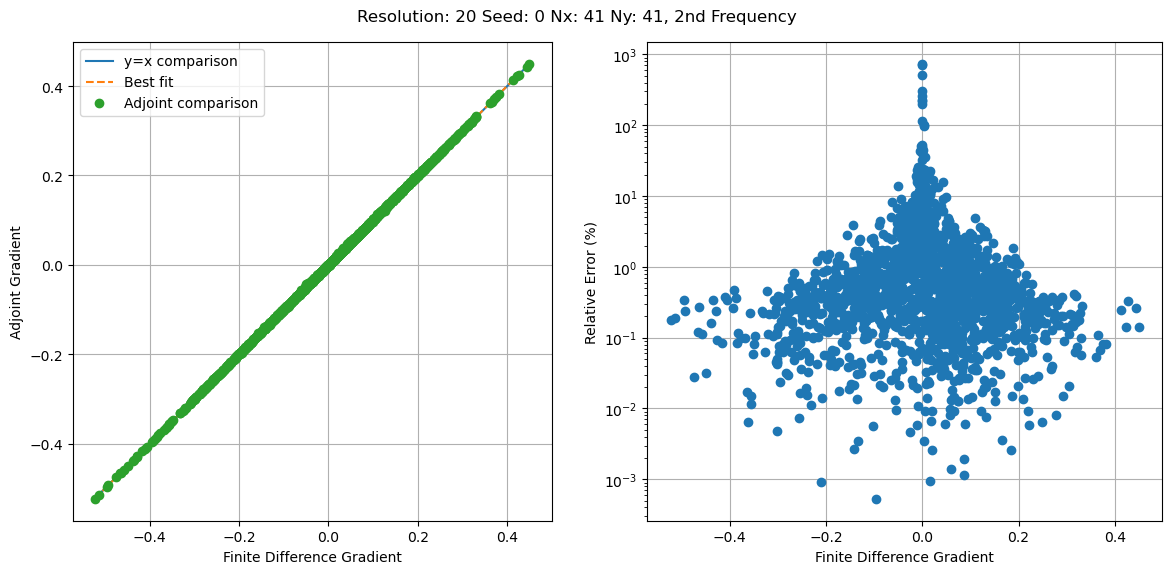

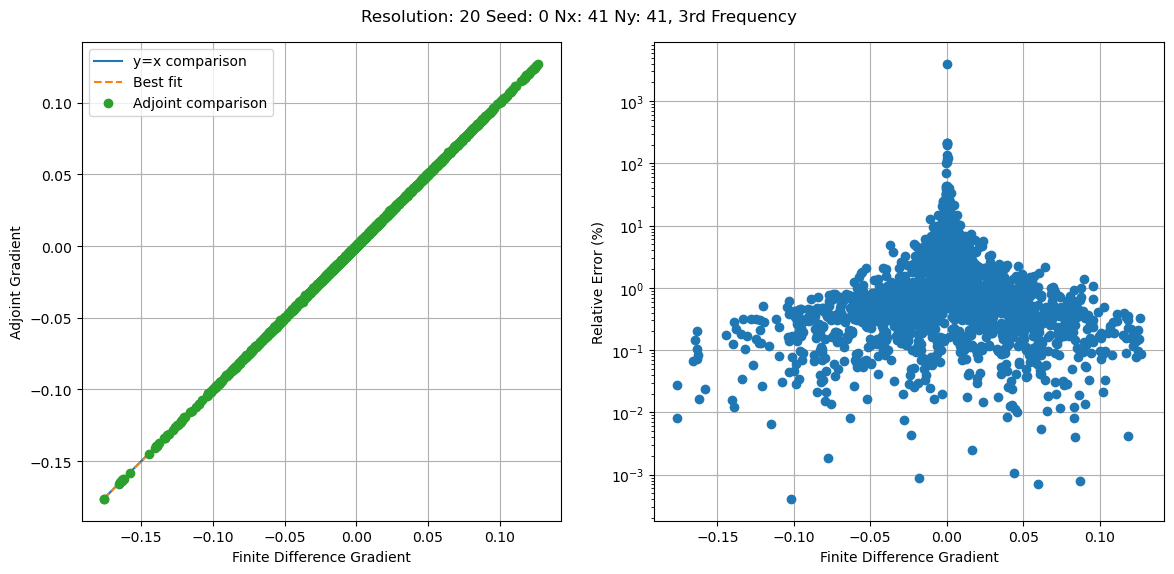

In [21]:
min_g_0 = np.min(g_discrete_0)
max_g_0 = np.max(g_discrete_0)
min_g_1 = np.min(g_discrete_1)
max_g_1 = np.max(g_discrete_1)
min_g_2 = np.min(g_discrete_2)
max_g_2 = np.max(g_discrete_2)
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g_0, max_g_0], [min_g_0, max_g_0], label="y=x comparison")
plt.plot([min_g_0, max_g_0], [m0 * min_g_0 + b0, m0 * max_g_0 + b0], "--", label="Best fit")
plt.plot(g_discrete_0, dJ_du_0[0,idx,0], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err_0 = (
    np.abs(np.squeeze(g_discrete_0) - np.squeeze(dJ_du_0[0,idx,0]))
    / np.abs(np.squeeze(g_discrete_0))
    * 100
)
plt.semilogy(g_discrete_0, rel_err_0, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}, 1st Frequency".format(resolution, 0, Nx, Ny))
plt.show()

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g_1, max_g_1], [min_g_1, max_g_1], label="y=x comparison")
plt.plot([min_g_1, max_g_1], [m1 * min_g_1 + b1, m1 * max_g_1 + b1], "--", label="Best fit")
plt.plot(g_discrete_1, dJ_du_1[0,idx,1], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err_1 = (
    np.abs(np.squeeze(g_discrete_1) - np.squeeze(dJ_du_1[0,idx,1]))
    / np.abs(np.squeeze(g_discrete_1))
    * 100
)
plt.semilogy(g_discrete_1, rel_err_1, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}, 2nd Frequency".format(resolution, 0, Nx, Ny))
plt.show()

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot([min_g_2, max_g_2], [min_g_2, max_g_2], label="y=x comparison")
plt.plot([min_g_2, max_g_2], [m2 * min_g_2 + b2, m2 * max_g_2 + b2], "--", label="Best fit")
plt.plot(g_discrete_2, dJ_du_2[0,idx,2], "o", label="Adjoint comparison")
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Adjoint Gradient")
plt.legend()
plt.grid(True)
plt.axis("square")

plt.subplot(1, 2, 2)
rel_err_2 = (
    np.abs(np.squeeze(g_discrete_2) - np.squeeze(dJ_du_2[0,idx,2]))
    / np.abs(np.squeeze(g_discrete_2))
    * 100
)
plt.semilogy(g_discrete_2, rel_err_2, "o")
plt.grid(True)
plt.xlabel("Finite Difference Gradient")
plt.ylabel("Relative Error (%)")

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle("Resolution: {} Seed: {} Nx: {} Ny: {}, 3rd Frequency".format(resolution, 0, Nx, Ny))
plt.show()